# Graph-tool and networkx

- Create a graph
- Clustering
- Centrality measures
- k-core decomposition
- assortativity
- Drawing

In [1]:
import networkx as nx
import graph_tool.all as gt

## Create a graph/network

In [2]:
G = nx.Graph()
g = gt.Graph(directed=False)

print(type(G))
print(type(g))

<class 'networkx.classes.graph.Graph'>
<class 'graph_tool.Graph'>


Adding some nodes/vertices

In [3]:
# networkx
G.add_node('a')
G.add_node('b')
print(G.nodes)
print('type of container:', type(G.nodes))

['a', 'b']
type of container: <class 'networkx.classes.reportviews.NodeView'>


`N` es el número de nodos de `g`. Entonces `graph-tool` asume que los nodos van de `0,...,N-1`. Para los nodos definidos como `string` usamos los (node/edge) PropertyMaps.

In [4]:
# vertex = node; edge = edge
a = g.add_vertex()
b = g.add_vertex()

In [5]:
label = g.new_vertex_property('string')
label[a] = 'a'
label[b] = 'b'

In [6]:
print(g.get_vertices())
print('type of container:', type(g.get_vertices()))

[0 1]
type of container: <class 'numpy.ndarray'>


Equivalently

In [7]:
g = gt.Graph(directed=False)
g.add_vertex(2)

<generator object Graph.add_vertex.<locals>.<genexpr> at 0x7f80f0a1bb30>

In [8]:
label = g.new_vertex_property('string')
label[0] = 'a'
label[1] = 'b'

In [9]:
print(g.get_vertices())
print('type of container:', type(g.get_vertices()))

[0 1]
type of container: <class 'numpy.ndarray'>


Adding an Edge

In [10]:
G.edges

EdgeView([])

In [11]:
G.add_edge('a', 'b')
print(G.edges)
print('container edges:', type(G.edges))

[('a', 'b')]
container edges: <class 'networkx.classes.reportviews.EdgeView'>


In [12]:
g.get_vertices().shape

(2,)

In [13]:
g.get_edges().shape

(0, 2)

In [14]:
g.add_edge(0, 1)
print(g.get_edges())
print('container edges:', type(g.get_edges()))

[[0 1]]
container edges: <class 'numpy.ndarray'>


Adding edgelist

In [15]:
edgelist = [['a', 'b'],
            ['a', 'd']]

In [16]:
G = nx.Graph()
G.add_edges_from(edgelist)
print(G.edges)

[('a', 'b'), ('a', 'd')]


In [17]:
edgelist = [[0, 1, 1, 3.],
            [1, 2, 0, 8.]]

In [19]:
g = gt.Graph(directed=False)
weight = g.new_edge_property('int')
strength = g.new_edge_property('float')
g.add_edge_list(edgelist, eprops=[weight, strength])
print(g.get_edges())

[[0 1]
 [1 2]]


Removing nodes and edges

In [20]:
print(G.edges)
G.remove_edge('a', 'b')
print(G.edges)

[('a', 'b'), ('a', 'd')]
[('a', 'd')]


In [21]:
print(g.get_edges())
g.remove_edge(g.edge(0, 1))
print(g.get_edges())

[[0 1]
 [1 2]]
[[1 2]]


# Les misérables network

Novel by Victor Hugo from 1862. The co-occurrence network was created by Donald E. Knuth in 1994.

It is a non-directed weighted network.

 - nodes: characters
 - links: co-appearance
 - weight: number of co-appearances

In [22]:
G = nx.les_miserables_graph()

Write graph in graphml and load it in graph-tool

In [23]:
nx.write_graphml(G, "../data/les_miserables.xml")

In [24]:
g = gt.load_graph("../data/les_miserables.xml")

Edge and vertex properties (only graph-tool)

In [25]:
labels = g.vertex_properties['_graphml_vertex_id']

In [ ]:
nodes = {}
for node in g.iter_vertices():
    nodes[labels[node]] = node

In [26]:
nodes = {labels[x]: x for x in g.iter_vertices()}

In [27]:
weight = g.edge_properties['weight']

## Number of nodes and edges

In [28]:
print("number of nodes", len(G), g.num_vertices())
print("number of edges", len(G.edges), g.num_edges())

number of nodes 77 77
number of edges 254 254


## Clustering

Given a node $u$, its clustering $c_u$ is defined as

$$c_u = \frac{2 T(u)}{deg(u)(deg(u)-1)},$$

where $T(u)$ is the number of triangles through node $u$ and
$deg(u)$ is the degree of $u$.

There is a definition of weighted graphs as well

## Weighted clustering networkx
$$c_u = \frac{1}{deg(u)(deg(u)-1))}
         \sum_{vw} (\hat{w}_{uv} \hat{w}_{uw} \hat{w}_{vw})^{1/3}.$$

The edge weights $\hat{w}_{uv}$ are normalized by the maximum weight
in the network $\hat{w}_{uv} = w_{uv}/\max(w)$.

The value of $c_u$ is assigned to 0 if $deg(u) < 2$.

## Weighted clustering graph-tool 
   $$c_i = \frac{|\{e_{jk}\}|}{k_i(k_i-1)} :\, v_j,v_k \in N_i,\, e_{jk} \in E$$

where $k_i$ is the out-degree of vertex $i$, and

 
   $$N_i = \{v_j : e_{ij} \in E\}$$

is the set of out-neighbors of vertex $i$. For undirected graphs the
value of $c_i$ is normalized as

 
   $$c'_i = 2c_i.$$

In [29]:
clust1 = nx.clustering(G)
clust2 = gt.local_clustering(g)

print('graph-tool', clust2[2])
print('networkx', clust1[labels[2]])

graph-tool 1.0
networkx 1.0


In [ ]:
clust1 = nx.clustering(G, weight='weight')
clust2 = gt.local_clustering(g, weight=weight)

print('graph-tool', clust2[1])
print('networkx', clust1[labels[1]])

Global clustering or average clustering

## Graph-tool

The global clustering coefficient [newman-structure-2003]_ $c$ is
defined as

$$
   c = 3 \times \frac{\text{number of triangles}}
                      {\text{number of connected triples}}
$$
If weights are given, the following definition is used:

$$
   c = \frac{\mathrm{Tr}{{\boldsymbol A}^3}}{\sum_{i\ne j}[{\boldsymbol A}^2]_{ij}},
$$
where $\boldsymbol A$ is the weighted adjacency matrix, and it is
assumed that the weights are normalized, i.e. $A_{ij} \le 1$.

In [30]:
c, se = gt.global_clustering(g)
print(f'Global clustering {c} with standard deviation per vertex {se}')

Global clustering 0.49893162393162394 with standard deviation per vertex 0.1150252486325887


In [31]:
sum(clust1.values()) / len(G)

0.5731367499320134

In [32]:
c = nx.average_clustering(G)
print(f'Average clustering {c}')

Average clustering 0.5731367499320134


# Summary

- Les misérables (77 nodes and 254 edges)
 - G -> `networkx` graph
 - g -> `graph_tool` graph
 - weight -> # of interactions in the novel
 
- clustering (`clus1` and `clust2`)

We can conlcude that les misérables social network is quite clustered. With an average clustering of 0.57 and global clustering of 0.5.

# Central nodes

### Betweenness
$$
   c_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}.
$$
where $V$ is the set of nodes, $\sigma(s, t)$ is the number of
shortest $(s, t)$-paths,  and $\sigma(s, t|v)$ is the number of
those paths  passing through some  node $v$ other than $s, t$.
If $s = t$, $\sigma(s, t) = 1$, and if $v \in {s, t}$,
$\sigma(s, t|v) = 0$.

In [68]:
max_bet[0]

('Valjean', 0.5699890527836184)

In [66]:
bet1 = nx.betweenness_centrality(G)
max_bet = sorted(bet1.items(), key=lambda x: -x[1])
bet1[max_bet[0][0]]

0.5699890527836184

In [72]:
bet2, ebet2 = gt.betweenness(g)
bet2[nodes[max_bet[0][0]]]

0.5699890527836186

### Closenness

Closeness centrality of a node $u$ is the reciprocal of the
average shortest path distance to $u$ over all $n-1$ reachable nodes.


$$
    C(u) = \frac{n - 1}{\sum_{v=1}^{n-1} d(v, u)},
$$
where $d(v, u)$ is the shortest-path distance between $v$ and $u$,
and $n$ is the number of nodes that can reach $u$.

In [83]:
clos1 = nx.closeness_centrality(G)
max_clos = sorted(clos1.items(), key=lambda x: -x[1])

In [85]:
clos2 = gt.closeness(g)
clos2[nodes[max_clos[0][0]]]

0.6440677966101694

- Because we have large clustering, we have large closenness as well.
- Closenness represents main characters

## $k$-core decomposition

A $k$-core is a maximal subgraph that contains nodes of degree k or more.

In [94]:
core1 = nx.core_number(G)
max_k = max(core1.values())
# List comprehension
[x for x in core1 if core1[x]==max_k]

['Gavroche',
 'Marius',
 'Mabeuf',
 'Enjolras',
 'Combeferre',
 'Prouvaire',
 'Feuilly',
 'Courfeyrac',
 'Bahorel',
 'Bossuet',
 'Joly',
 'Grantaire']

In [111]:
core2 = gt.kcore_decomposition(g)
core2.a

PropertyArray([1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 8, 1, 2, 1, 1, 1, 7, 7, 7, 7,
               7, 7, 7, 7, 7, 8, 6, 8, 2, 6, 2, 3, 1, 2, 6, 6, 6, 6, 6, 2,
               1, 8, 3, 3, 2, 1, 1, 1, 9, 4, 2, 4, 2, 1, 4, 9, 2, 9, 9, 9,
               9, 9, 9, 9, 9, 9, 9, 1, 8, 8, 8, 8, 3, 2, 2, 7, 7],
              dtype=int32)

Friends of the ABC members:

- Bahorel – An idler from a peasant background who connects the Friends of the ABC with similar societies. 
- Combeferre – "The Guide". Representing the philosophy of the revolution, he "completes and corrects" Enjolras. 
- Courfeyrac (also de Courfeyrac) – "The Center". 
- Enjolras – "The Chief". Youthful, handsome, and charming, though "capable of being terrible", he is the leader of the Friends of the ABC. 
- Feuilly – An orphaned fan maker who taught himself to read and write.
- Grantaire – A sceptic with no interest in revolution. 
- Jean Prouvaire (also Jehan) – Described as softer than Combeferre, Jean Prouvaire is a poet who calls himself Jehan due to his interest in the Middle Ages. 
- Joly (also Jolllly) – A hypochondriac student of medicine.
- Lesgle

The main core is a highly inter-connected subgraph perhaps not related to main protagonists.

## Assortativity (graph-tool)
The assortativity coefficient tells in a concise
fashion how vertices of different types are preferentially connected amongst
themselves, and is defined by

$$
    r = \frac{\sum_i e_{ii} - \sum_i a_i b_i}{1-\sum_i a_i b_i}
$$
where $a_i=\sum_je_{ij}$ and $b_j=\sum_ie_{ij}$, and
$e_{ij}$ is the fraction of edges from a vertex of type
i to a vertex of type j.

In [118]:
print('networkx', nx.degree_assortativity_coefficient(G))
print('graph-tool', gt.assortativity(g, 'total'))

networkx -0.16522513442236916
graph-tool (0.08456960858268378, 0.023299027077343094)


## Drawing

In [119]:
pos1 = gt.sfdp_layout(g)

In [132]:
# Dictionary comprehension
pos2 = {labels[x]: pos1[x] for x in g.iter_vertices()}

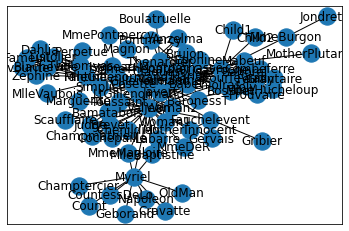

In [133]:
nx.draw_networkx(G, pos=pos2)

In [139]:
core1

{'Napoleon': 1,
 'Myriel': 3,
 'MlleBaptistine': 3,
 'MmeMagloire': 3,
 'CountessDeLo': 1,
 'Geborand': 1,
 'Champtercier': 1,
 'Cravatte': 1,
 'Count': 1,
 'OldMan': 1,
 'Valjean': 8,
 'Labarre': 1,
 'Marguerite': 2,
 'MmeDeR': 1,
 'Isabeau': 1,
 'Gervais': 1,
 'Listolier': 7,
 'Tholomyes': 7,
 'Fameuil': 7,
 'Blacheville': 7,
 'Favourite': 7,
 'Dahlia': 7,
 'Zephine': 7,
 'Fantine': 7,
 'MmeThenardier': 7,
 'Thenardier': 8,
 'Cosette': 6,
 'Javert': 8,
 'Fauchelevent': 2,
 'Bamatabois': 6,
 'Perpetue': 2,
 'Simplice': 3,
 'Scaufflaire': 1,
 'Woman1': 2,
 'Judge': 6,
 'Champmathieu': 6,
 'Brevet': 6,
 'Chenildieu': 6,
 'Cochepaille': 6,
 'Pontmercy': 2,
 'Boulatruelle': 1,
 'Eponine': 8,
 'Anzelma': 3,
 'Woman2': 3,
 'MotherInnocent': 2,
 'Gribier': 1,
 'MmeBurgon': 1,
 'Jondrette': 1,
 'Gavroche': 9,
 'Gillenormand': 4,
 'Magnon': 2,
 'MlleGillenormand': 4,
 'MmePontmercy': 2,
 'MlleVaubois': 1,
 'LtGillenormand': 4,
 'Marius': 9,
 'BaronessT': 2,
 'Mabeuf': 9,
 'Enjolras': 9,
 'Comb

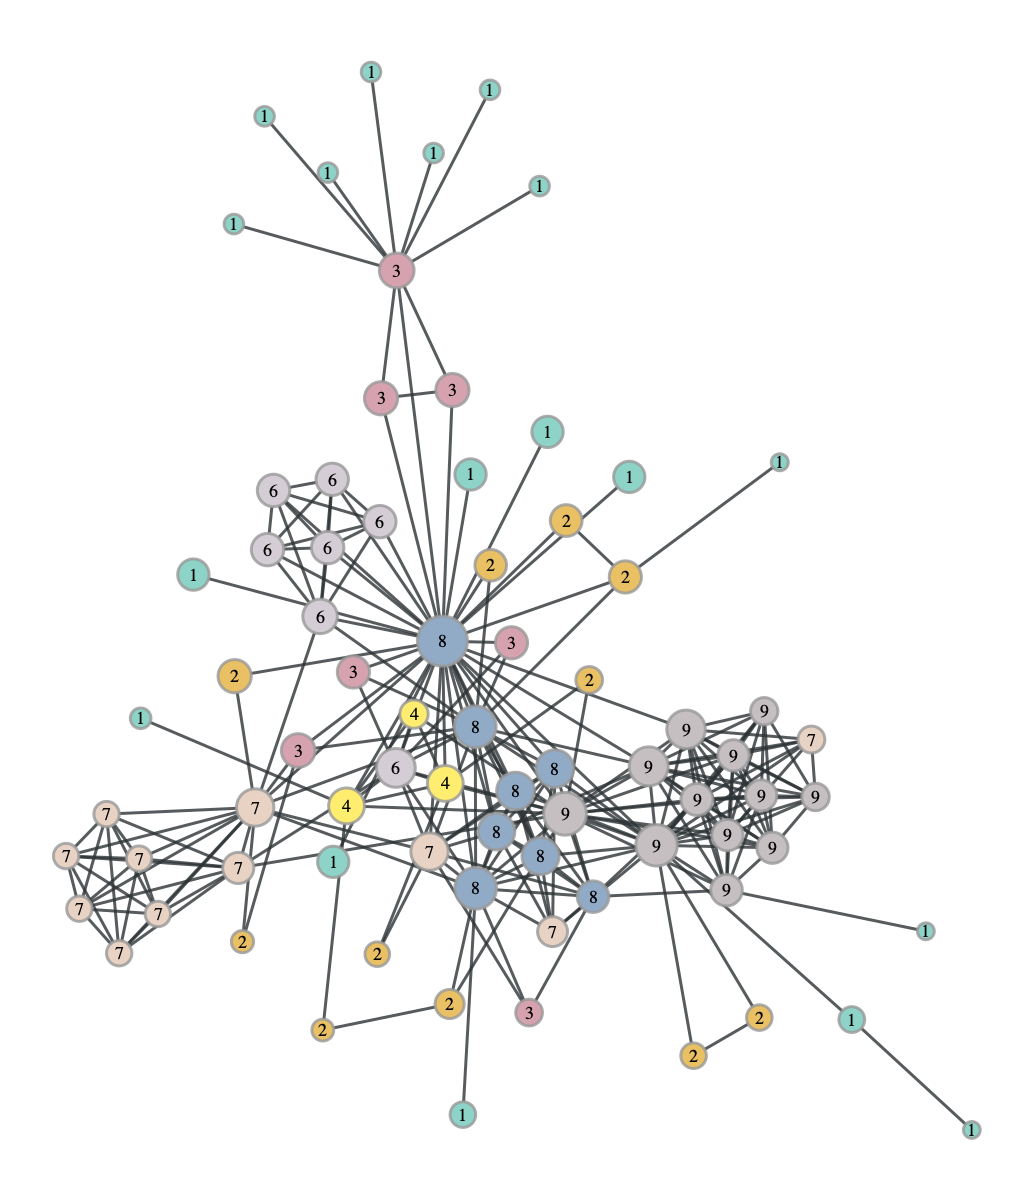

In [138]:
gt.graph_draw(g, pos=pos1, vertex_fill_color=core2, vertex_text=core2,
              vertex_size=gt.prop_to_size(clos2, mi=2, ma=25));